Dans cet article, nous allons modéliser une régression polynomiale permettant de prédire les frais médicaux d'un patient (la variable 'charges') en fonction de différentes données (l'âge, le sexe, le fait d'être fumeur, etc).  
<p> 
    Nous allons essayer de déterminer le degré du polynome optimal pour minimiser l'erreur du modèle et nous tracerons également les courbes d'apprentissage des set d'entrainement et de validation.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('insurance.csv')

In [3]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


On transforme la variable catégorielle 'smoker' en variable binaire (0 si non fumeur, 1 si fumeur)

In [4]:
dataset.dropna()
dataset['smoker'] = dataset['smoker'].map({'yes': 1, 'no': 0})
dataset['smoker'] = dataset['smoker'].astype('int64')
dataset['sex'] = dataset['sex'].map({'male': 1, 'female': 0})
dataset['sex'] = dataset['sex'].astype('int64')

On observe les différentes corrélations par rapport à la variable 'charges'

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'sex'),
  Text(0, 2.5, 'bmi'),
  Text(0, 3.5, 'children'),
  Text(0, 4.5, 'smoker'),
  Text(0, 5.5, 'charges')])

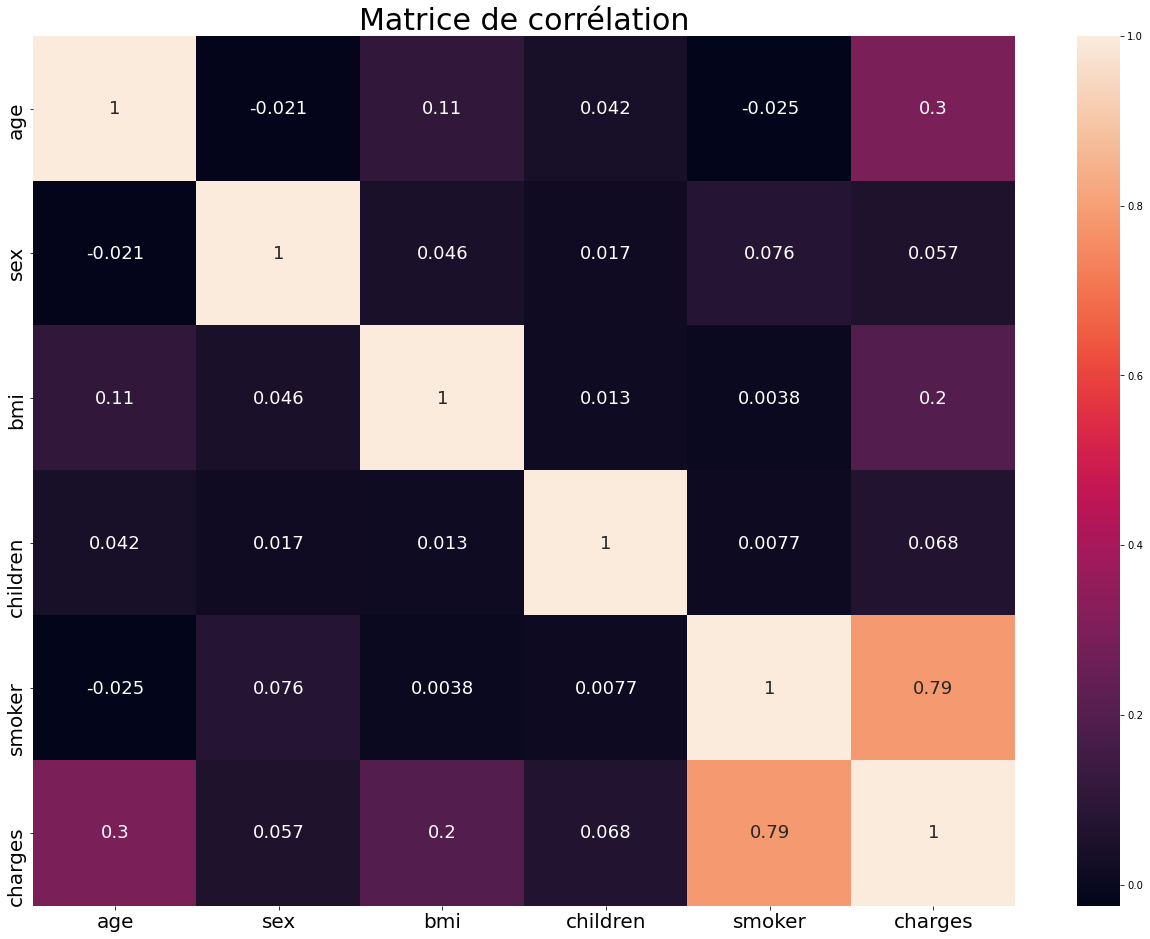

In [5]:
plt.figure(figsize = (22,16))
sns.heatmap(dataset.corr(), annot = True, annot_kws={"size": 18})
plt.title('Matrice de corrélation', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

La variable 'smoker' est plus fortement correlée. Toutefois, pour notre modèle, nous avons choisis d'utiliser toutes les variables (hormis la variable 'region'). 

In [6]:
columns = ['age', 'sex', 'bmi', 'smoker']
X = dataset[columns].values
X = (X - np.mean(X))/np.std(X) #Standardisation

y = dataset['charges'].values
y = y.reshape((y.shape[0],1))

On divise le dataset en  :
- Un training set représentant 80% des données
- Un test set représentant 20% des données

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

On cherche le degré du polynome le plus adéquat en utilisant sklearn et la [validation croisée](https://www.kevindegila.com/la-validation-croisee-en-machine-learning-tout-ce-quil-faut-savoir/). On divise notre train_set en 5 parties pour la cross-validation.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def degreeOpti(dmax=10):
    listMse = list()
    for i in range(1,dmax+1):
        poly = PolynomialFeatures(degree=i)
        Xi = poly.fit_transform(X_train)
        listMse.append(-1*cross_val_score(
            LinearRegression(), Xi, y_train, cv = 5, scoring = 'neg_mean_squared_error').mean())
    return listMse

In [9]:
listMse = degreeOpti(15)
print('Le modèle avec la plus faible MSE est le modèle de degré : '+str(np.argmin(listMse)))

Le modèle avec la plus faible MSE est le modèle de degré : 2


En utilisant la Mean Squared Error, on observe que le modèle le plus efficace est la régression polynomiale de degré 2. C'est donc lui que nous sélectionnons comme modèle final.

In [10]:
poly = PolynomialFeatures(degree=2)
X2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)
model = LinearRegression().fit(X2, y_train)

On trace les courbes d'apprentissage pour voir la variation de la performance du modèle en fonction du nombre de données

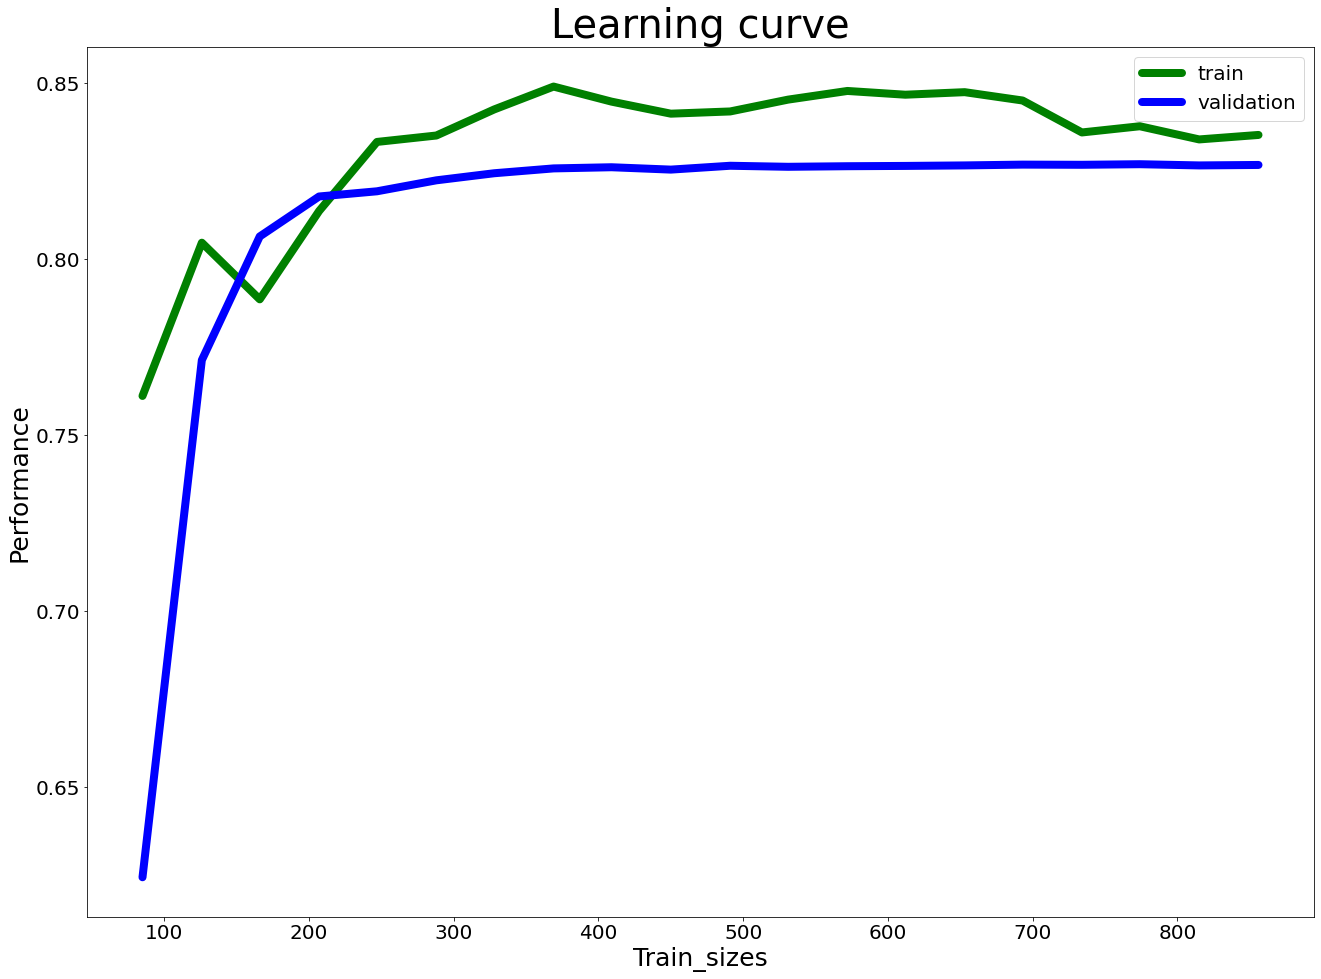

In [11]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(
    model, X2, y_train, train_sizes = np.linspace(0.1,1.0,20), cv = 5)

plt.figure(figsize = (22,16))

plt.plot(N, train_score.mean(axis = 1), label = 'train', c = 'green', linewidth=8, 
         solid_capstyle="round")
plt.plot(N, val_score.mean(axis = 1), label = 'validation', c = 'blue', linewidth=8, 
         solid_capstyle="round")

plt.xlabel('Train_sizes', fontsize = 25)
plt.ylabel('Performance', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Learning curve', fontsize = 40)
plt.legend(fontsize = 20)

In [12]:
print('Coefficient de détermination (R²) du modèle : '+str(int(model.score(X_test2, y_test)*100))+'%')

Coefficient de détermination (R²) du modèle : 85%


On obtient un R² de 85% ce qui signifie que notre modèle permet de déterminer 85% du jeu de test, notre modèle est donc plutôt bon. Egalement sur le graphique, on voit que les 2 courbes d'apprentissage tendent à converger et qu'augmenter le nombre de données d'entrainement n'améliorera que peu le modèle.